## Initialization

### Start

In [1]:
universityStorage = True

In [2]:
guy_folder = "/home/olab/amnlp2020/guy_ariel/guy/" if universityStorage else "/content"

### Install

In [3]:
%pip install matplotlib seaborn pandas tqdm tensorboard

%cd {guy_folder}
!mkdir torch-transformers-cache

%cd {guy_folder}
!mkdir datasets
!mkdir torch-transformers-cache

%pip install --no-cache-dir torch==1.4.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

%cd {guy_folder}/torch-transformers-cache/
!git clone https://github.com/huggingface/transformers.git
%pip install ./transformers
%pip install -U nlp

%cd {guy_folder}
## Not working!!!
!setenv TRANSFORMERS_CACHE /vol/scratch/guy/torch-transformers-cache
!setenv CUDA_VISIBLE_DEVICES 0

  Using cached matplotlib-3.3.1-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached pandas-1.1.1-cp38-cp38-manylinux1_x86_64.whl (10.4 MB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached numpy-1.19.1-cp38-cp38-manylinux2010_x86_64.whl (14.5 MB)
  Using cached Pillow-7.2.0-cp38-cp38-manylinux1_x86_64.whl (2.2 MB)
  Using cached kiwisolver-1.2.0-cp38-cp38-manylinux1_x86_64.whl (92 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached scipy-1.5.2-cp38-cp38-manylinux1_x86_64.whl (25.7 MB)
  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
     |################################| 93 kB 82 kB/s  eta 0:00:01
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
  Using cached grpcio-1.31.0-cp38-cp38-manylinux2014_x86_64.whl (3.4 MB)
  Using cached protobuf-3.13.0-cp38-cp38-manylinux1_x86_64.whl (1.3 MB)

### Update Transformers

In [ ]:
%cd {guy_folder}/torch-transformers-cache/transformers
!git pull
%pip install -e .

/specific/scratches/scratch/guy/torch-transformers-cache/transformers
Already up-to-date.
Obtaining file:///specific/scratches/scratch/guy/torch-transformers-cache/transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2
  Running setup.py develop for transformers
Note: you may need to restart the kernel to use updated packages.


### Imports

In [5]:
%pip install scikit-learn

  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
cache_dir = guy_folder + "/torch-transformers-cache/"
import torch
import sklearn # Order important - torch before sklearn (had to install and uninstall stuff until worked, not sure why)
from tokenizers import Tokenizer
import transformers
from transformers import AutoModel, AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import re, pdb
import itertools
%matplotlib inline
%cd {guy_folder}

from tqdm import tqdm_notebook, trange, tqdm
from torch.functional import F
from torch import nn
from torch.nn import Sequential
from torch.nn import Linear
import scipy
import wandb


/specific/netapp5_3/rent_public/olab-01-08-2021/amnlp2020/guy_ariel/guy


In [ ]:
import plotly.offline as ply
ply.init_notebook_mode()

### Load Data

In [12]:
%cd {guy_folder}
inputs_memmap = np.memmap("inputs.memmap", dtype = 'float32', shape = (100, 12, 12, 60, 60))
target_memmap = np.memmap("target.memmap", dtype = 'float32', shape = (100, 24, 16, 60, 60))

/specific/netapp5_3/rent_public/olab-01-08-2021/amnlp2020/guy_ariel/guy


In [13]:
a = inputs_memmap.transpose((1,2,0,3,4)) 
a = a.reshape((a.shape[0] * a.shape[1], -1, a.shape[-1]))
b = target_memmap.transpose((1,2,0,3,4))
b = b.reshape((b.shape[0] * b.shape[1], -1, b.shape[-1]))

In [14]:
sim_arr = np.empty((a.shape[0], b.shape[0]))
sim_arr[:] = None

In [15]:
sim_memmap = np.memmap("sim_arr.memmap", dtype = sim_arr.dtype, shape = sim_arr.shape, mode = 'r')
sim_arr = sim_memmap[:]

## Functions

In [16]:
def _js_div(x,y):
    m = .5 * (x + y)
    return .5 * (np.nansum(scipy.special.rel_entr(x, m))  + np.nansum(scipy.special.rel_entr(y, m)))

def maskify(vect): 
    a = np.concatenate(list(map(lambda x: list(zip(itertools.repeat(x[0]), x[1])), list(enumerate(vect)))))
    return list(zip(*a.tolist()))

def topk(a, k): 
    assert(len(a.shape) == 2)
    return np.argsort(a, axis = -1)[:, -k:][:, ::-1]

def _getAttentionsReshaped(outputs, wordsToTokens = None, layerwise = False, reshape = True):
    attentions_ = outputs[-1]#.attentions # (n_layers, batch, n_heads, N, N) TODO: Verify!
    attentions = torch.stack(attentions_).permute(0, 2, 1, 3, 4)
    if wordsToTokens is not None:
        shape = (attentions.size(0), attentions.size(1), -1) if layerwise else (attentions.size(0) * attentions.size(1), -1)
        attentions = _combineTokensByWords(attentions, wordsToTokens)
        assert((abs(attentions.sum(axis = -1) - 1) < 0.1).all())
        if reshape:
          attentions = attentions.reshape(*shape)
    else:
        if reshape:
          attentions = attentions.reshape(attentions.size(0) * attentions.size(1), -1, attentions.size(-1))
    if not reshape:
        attentions = torch.squeeze(attentions)
    return attentions


def _combineTokensByWords(attentions, wordsToTokens): # Both rows & columns
        nTokens = sum(wordsToTokens)
        nWords = len(wordsToTokens)
        s = np.zeros((nTokens, nWords))
        weights = sum([[1./a] * a for a in wordsToTokens], [])
        wordNum = sum([[i]*a for i, a in enumerate(wordsToTokens)], [])
        s[list(range(nTokens)), wordNum] = weights
        s = torch.FloatTensor(s)
        return s.T @ attentions @ s

def _wordsToTokensByOffset(sent, offsets): # Not gonna document this 
    wordOffsets = [-1]+list(map(lambda x: x.span()[0], (re.finditer(r'\s+', sent))))+[len(sent)+1]
    offsets = list(map(lambda x: x[0], offsets)) 
    zWords = list(zip(wordOffsets, itertools.repeat("word")))
    zTokens = list(zip(offsets, itertools.repeat("token")))
    s = sorted(itertools.chain(zWords, zTokens), key = lambda x: x[0])
    lensArr = np.diff([i for i, a in enumerate(s) if a[1] == 'word'])-1
    return lensArr


def tokenizeSentencesNoPadding(tokenizers, sentences):
    output = []
    modelsWordsToTokens = []
    for tokenizer in tokenizers:
        output += [[]]
        modelsWordsToTokens += [[]]
        print(tokenizer.__class__)
        for sent in tqdm(sentences):
            tokenized_sent = tokenizer(sent, pad_to_max_length = False, max_length=60, return_tensors='pt', 
                                       return_offsets_mapping = True,
                                       truncation = True)
            
            tokenOffsets = (tokenized_sent.pop('offset_mapping').numpy()[0]).tolist() #TODO: Make sure the 0-index does the right thing
            modelsWordsToTokens[-1]+=[ _wordsToTokensByOffset(sent, tokenOffsets) ]
            output[-1]+=[ tokenized_sent]
    return zip(output, modelsWordsToTokens)

def headSimilarityNoPadding(modelA, modelB, encodedA_list, encodedB_list, 
                                           wordsToTokensA_list, wordsToTokensB_list):
    res = None
    for (encodedA, encodedB, wordsToTokensA, wordsToTokensB) in tqdm(
                                        zip(encodedA_list, encodedB_list,
                                          wordsToTokensA_list, wordsToTokensB_list), total = len(encodedA_list)):

        N = len(wordsToTokensA) # TODO: Fix N to the right formula
        attentionsA = _getAttentionsReshaped(modelA(**encodedA), wordsToTokens = wordsToTokensA).detach().numpy()
        attentionsB = _getAttentionsReshaped(modelB(**encodedB), wordsToTokens = wordsToTokensB).detach().numpy() 
        
        new_res = klDivAllPairs(attentionsA, attentionsB, N)
        if res is None:
            res = new_res
        else:
            res += new_res
    
    return res/len(encodedA_list)


def _getSentLen(sent):
  assert(len(sent.shape) == 1)
  a = np.where(np.isnan(sent))[0]
  if len(a) == 0:
    return (sent.shape[0])
  else:
    return a[0]



## Visualization

### Head Similarity

In [13]:
%%script false
for j, y in enumerate(b):
    for i, x in tqdm(enumerate(a), desc="inputs"):
        sim_arr[i, j] = _js_div(x,y)

inputs: 0it [00:00, ?it/s]


NameError: name 'scipy' is not defined

In [14]:
%%script false
%cd {guy_folder}
sim_memmap = np.memmap("sim_arr.memmap", dtype = sim_arr.dtype, shape = sim_arr.shape, mode = 'w+')
sim_memmap[:] = sim_arr[:]
sim_memmap.flush()

CalledProcessError: Command 'b'\n#%cd {guy_folder}\nsim_memmap = np.memmap("sim_arr.memmap", dtype = sim_arr.dtype, shape = sim_arr.shape, mode = \'w+\')\nsim_memmap[:] = sim_arr[:]\nsim_memmap.flush()\n'' returned non-zero exit status 1.

<AxesSubplot:>

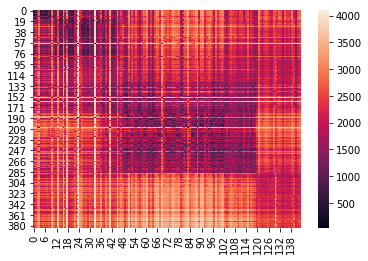

In [12]:
sns.heatmap(sim_arr.T)

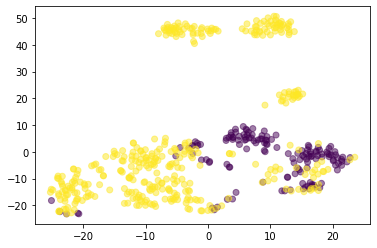

In [173]:
c1 = (np.arange(144)/12.).astype(int)
c2 = (np.arange(384)/16.).astype(int) + 12
c = np.concatenate([c1,c2])
plt.scatter(tsne_values[:, 0],tsne_values[:, 1], c = c >= 12, alpha = 0.5);

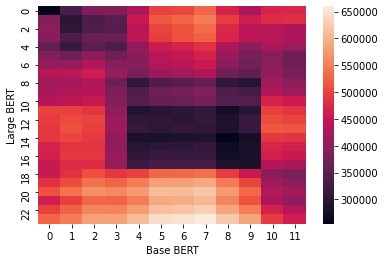

In [17]:
sim_arr_reshaped = (sim_arr.reshape((12,12,24, 16)) # TODO: Check dims correct
                    .transpose((0,2,1,3))
                    .reshape((12, 24, -1))) 
sns.heatmap(sim_arr_reshaped.sum(axis = -1).T)
plt.ylabel("Large BERT")
plt.xlabel("Base BERT");

<AxesSubplot:>

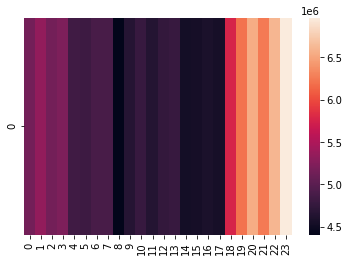

In [110]:
sns.heatmap([sim_arr_reshaped.sum(axis = -1).T.sum(axis = -1)])

In [18]:
(maskify(topk(-sim_arr.T, 3)))

[(0,
  0,
  0,
  1,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  3,
  4,
  4,
  4,
  5,
  5,
  5,
  6,
  6,
  6,
  7,
  7,
  7,
  8,
  8,
  8,
  9,
  9,
  9,
  10,
  10,
  10,
  11,
  11,
  11,
  12,
  12,
  12,
  13,
  13,
  13,
  14,
  14,
  14,
  15,
  15,
  15,
  16,
  16,
  16,
  17,
  17,
  17,
  18,
  18,
  18,
  19,
  19,
  19,
  20,
  20,
  20,
  21,
  21,
  21,
  22,
  22,
  22,
  23,
  23,
  23,
  24,
  24,
  24,
  25,
  25,
  25,
  26,
  26,
  26,
  27,
  27,
  27,
  28,
  28,
  28,
  29,
  29,
  29,
  30,
  30,
  30,
  31,
  31,
  31,
  32,
  32,
  32,
  33,
  33,
  33,
  34,
  34,
  34,
  35,
  35,
  35,
  36,
  36,
  36,
  37,
  37,
  37,
  38,
  38,
  38,
  39,
  39,
  39,
  40,
  40,
  40,
  41,
  41,
  41,
  42,
  42,
  42,
  43,
  43,
  43,
  44,
  44,
  44,
  45,
  45,
  45,
  46,
  46,
  46,
  47,
  47,
  47,
  48,
  48,
  48,
  49,
  49,
  49,
  50,
  50,
  50,
  51,
  51,
  51,
  52,
  52,
  52,
  53,
  53,
  53,
  54,
  54,
  54,
  55,
  55,
  55,
  56,
  56,
  56,
  57

<ipython-input-112-a4cafd059114>:5: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



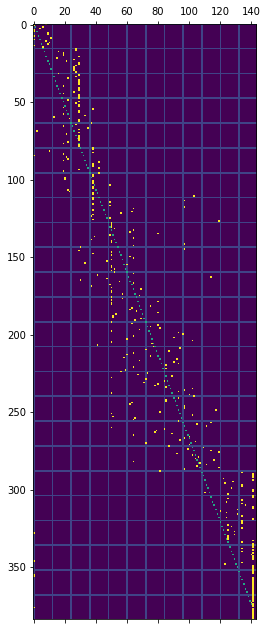

In [112]:
mat = np.zeros_like(sim_arr.T)
mat[::16, :] = 1
mat[:, ::12] = 1
mat[(383/143. * np.arange(0, 142)).astype(int), np.arange(0, 142)] = 3
mat[maskify(topk(-sim_arr.T, 1))] = [5]*(24*16)
plt.matshow(mat)

In [22]:
list(zip(*np.unique(topk(-sim_arr.T, 3).ravel(), return_counts=True)))

[(0, 22),
 (1, 1),
 (2, 3),
 (3, 2),
 (4, 12),
 (5, 2),
 (6, 8),
 (8, 3),
 (9, 5),
 (10, 4),
 (11, 4),
 (12, 1),
 (13, 2),
 (14, 2),
 (15, 7),
 (16, 4),
 (17, 3),
 (18, 1),
 (19, 39),
 (20, 11),
 (21, 27),
 (22, 6),
 (23, 6),
 (24, 5),
 (25, 1),
 (26, 13),
 (27, 32),
 (28, 2),
 (29, 53),
 (30, 4),
 (31, 1),
 (33, 5),
 (35, 4),
 (36, 3),
 (37, 12),
 (38, 47),
 (39, 4),
 (41, 3),
 (42, 27),
 (43, 2),
 (45, 1),
 (47, 5),
 (48, 1),
 (49, 13),
 (50, 52),
 (51, 4),
 (52, 8),
 (53, 6),
 (55, 4),
 (56, 7),
 (57, 16),
 (58, 3),
 (59, 4),
 (60, 9),
 (61, 2),
 (62, 23),
 (63, 7),
 (64, 32),
 (65, 6),
 (66, 5),
 (67, 2),
 (68, 6),
 (69, 4),
 (70, 7),
 (71, 3),
 (72, 5),
 (73, 4),
 (74, 6),
 (75, 4),
 (76, 3),
 (77, 3),
 (78, 6),
 (79, 4),
 (80, 19),
 (81, 8),
 (82, 2),
 (83, 2),
 (84, 5),
 (85, 13),
 (86, 4),
 (87, 5),
 (88, 1),
 (89, 4),
 (90, 3),
 (91, 3),
 (92, 3),
 (93, 7),
 (94, 4),
 (95, 4),
 (96, 6),
 (97, 56),
 (98, 1),
 (99, 3),
 (100, 10),
 (101, 3),
 (102, 8),
 (103, 3),
 (104, 3),
 (10

In [133]:
np.unique(topk(sim_arr.T, 3).ravel(), return_counts=True)

(array([  3,  16,  18,  23,  24,  33,  36,  41,  51,  69,  72,  83,  91,
        121, 139]),
 array([  7,  22, 180,   1, 361, 353,   1, 131,   7,  71,   2,   3,   1,
         11,   1]))

In [ ]:
# Head 2-0 (3-1)
# Head 2-9 (3-10)
# Head 1-6 (2-7)
# Head 3-5 (4-6)
# Head 5-9 (6-10)

<AxesSubplot:>

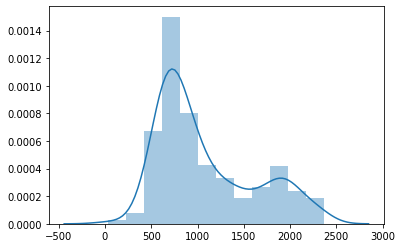

In [113]:
sns.distplot(sim_arr.T[np.arange(sim_arr.T.shape[0]), topk(-sim_arr.T, 1)[:, 0]])

### t-SNE

In [12]:
from sklearn.manifold import TSNE

In [25]:
shape = inputs_memmap.shape
shape = [shape[0],-1, shape[-2], shape[-1]]
all_attentions = np.concatenate([target_memmap.reshape(shape), inputs_memmap.reshape(shape)], axis = 1)

In [ ]:
%%script false
all_heads_sim = np.zeros((all_attentions.shape[1], all_attentions.shape[1]))
for all_heads in tqdm(all_attentions):
    all_heads_sim += np.array([[_js_div(x, y) for x in all_heads] for y in all_heads])

all_heads_sim_memmap = np.memmap("all_heads_sim.memmap",dtype = all_heads_sim.dtype, 
                                 shape = all_heads_sim.shape, mode = 'w+')

all_heads_sim_memmap[:] = all_heads_sim
all_heads_sim_memmap.flush()

  6%|▌         | 6/100 [14:30<3:46:45, 144.74s/it]

In [25]:
all_heads_sim = np.memmap("all_heads_sim.memmap",dtype = 'float64', 
                                 shape = (528, 528), mode = 'r')

In [104]:
print("J")

J


<AxesSubplot:>

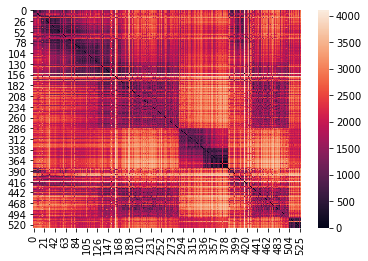

In [177]:
sns.heatmap(all_heads_sim)

In [102]:
from sklearn.manifold import TSNE
p = 30
tsne = TSNE(n_components = 2, metric='precomputed', perplexity=p)
tsne_values = tsne.fit_transform(all_heads_sim)

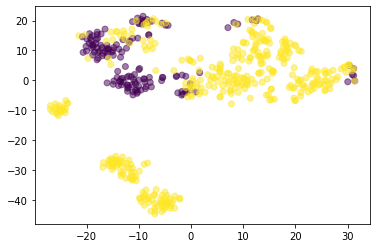

In [103]:
c1 = (np.arange(144)/12.).astype(int)
c2 = (np.arange(384)/16.).astype(int) + 12
c = np.concatenate([c1,c2])

plt.scatter(tsne_values[:, 0],tsne_values[:, 1], c = c >= 12, alpha = 0.5);

In [97]:
%%script false
# bad_ = np.nonzero(tsne_values[:, 0] > 14)[0]
bad_ = np.array([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
       379, 380, 381, 382, 383, 504, 505, 506, 507, 508, 509, 510, 511,
       512, 513, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527])


good_mask = np.ones_like(all_heads_sim)
good_mask[bad_, :] = 0
good_mask[:, bad_] = 0
good_mask = good_mask.astype('bool')

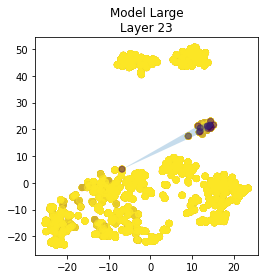

In [168]:
fig = plt.figure(figsize = (4, 4))
ax = fig.gca()
def animate(i):
#     plt.text(10, 0, )
    [patch.remove() for patch in reversed(ax.patches)]
    p = ax.scatter(tsne_values[:,0], tsne_values[:,1], c = c != i, alpha = 0.5)
    plt.title("Model {}\nLayer {}".format("Base" if i < 12 else "Large",
                                             i if i < 12 else i-12))
    pts = tsne_values[c == i]
    
    return [p, 
            ax.add_patch(plt.Polygon(pts[ConvexHull(pts).vertices], alpha = 0.25))]

HTML(animation.FuncAnimation(fig, animate, 
                             interval = 500, frames = 24+12, blit = True).to_jshtml())

In [26]:
from sklearn.manifold import TSNE
p = 30
tsne = TSNE(n_components = 3, metric='precomputed', perplexity=p)
tsne_values = tsne.fit_transform(all_heads_sim)

In [62]:
%%script false
ply.iplot([go.Scatter3d(x = tsne_values[:, 0],
                               y = tsne_values[:, 1], 
                               z = tsne_values[:, 2],
                               mode = 'markers',
                               marker = dict(opacity = 0.1,
                                color = (c < 12).astype(int).tolist())
                       )]);

CalledProcessError: Command 'b"ply.iplot([go.Scatter3d(x = tsne_values[:, 0],\n                               y = tsne_values[:, 1], \n                               z = tsne_values[:, 2],\n                               mode = 'markers',\n                               marker = dict(opacity = 0.1,\n                                color = (c < 12).astype(int).tolist())\n                       )]);\n"' returned non-zero exit status 1.

In [ ]:
k = 3
inputs_memmap = inputs_memmap.reshape((len(inputs_memmap), -1, 60, 60))
target_memmap = target_memmap.reshape((len(inputs_memmap), -1, 60, 60))
bestVals = np.zeros((target_memmap.shape[1], len(inputs_memmap), k))

for i in tqdm_notebook(range(len(inputs_memmap))):
    X = inputs_memmap[i]
    Y = target_memmap[i]
    
    for j, x in enumerate(X):
        xVals = np.zeros((len(y),))
        for k, y in enumerate(Y):
            xVals[k] = (_js_div(x, y))
        
        bestVals[j, i] = topk(-xVals, k)

## Predict Attention Heads

### Weighted Sum

In [9]:
class AttentionCombiner(nn.Module):
    def __init__(self, n_total_heads = 12 * 12, c = 1./100):
        super(AttentionCombiner, self).__init__()
        self.n_total_heads = n_total_heads
        self.weight = nn.Parameter(torch.ones((self.n_total_heads,1, 1)) * c)
        

    def init_weights(self, a = 0):
        nn.init.constant_(self.weight, a)
        
    def forward(self, x):
        x = x.view(self.n_total_heads, x.size(2), x.size(3))
        w = F.softmax(self.weight)
        # w /= w.sum(axis = 0, keepdims = True)
        x = (w * x).sum(axis = 0)
        return x #F.softmax(x, dim = -1)

class AttentionConverter(nn.Module):
    def __init__(self):
        super(AttentionConverter, self).__init__()
        self.combiner1 = AttentionCombiner()
        self.combiner2 = AttentionCombiner()
        self.combiner3 = AttentionCombiner()

#         self.cnn = nn.Conv1d(1, 1, 3, padding = 1)
#         nn.init.xavier_uniform_(self.cnn.weight)

    def forward(self, x):
        shape = x.shape
#         x = self.cnn(x.view(-1, 1, x.size(-1)))
#         x = x.view(*shape)
        x = (self.combiner1(x) + self.combiner2(x) + self.combiner3(x))/3    
        return x #F.softmax(x.view(x.size(-1), x.size(-1)), dim = -1)

In [21]:
attConv = AttentionCombiner()
optimizer = torch.optim.Adam(attConv.parameters(), lr = 5e-3)
criterion = nn.KLDivLoss(reduction = 'batchmean')
avg_loss = np.empty((24,16))
beta = 0.95
scheduler = (torch.optim.lr_scheduler
             .ReduceLROnPlateau(optimizer, factor = 0.5, patience = 3, 
                                                       threshold = 1e-2,
                                                       min_lr = 1e-4,
                                                      verbose = True))
for layer in range(24):
    for head in range(16):
        for e in range(30):
            print("Epoch " + str(e))
            t = tqdm(range(len(inputs_memmap)))
            for i in t:
              attConv.zero_grad()
              cur_inputs = inputs_memmap[i]
              cur_target = target_memmap[i, 10, 0]

              sent_len = _getSentLen(cur_target[0])
              inputs = torch.from_numpy(np.array(cur_inputs[:,:, :sent_len, :sent_len])).detach()
              target = torch.from_numpy(np.array(cur_target[ :sent_len, :sent_len])).detach()
              loss = criterion(torch.log(attConv(inputs)), target)

              if not avg_loss[layer, head]:
                    avg_loss[layer, head] = loss.item()
              avg_loss[layer, head] = beta * avg_loss[layer, head] + (1-beta) * loss.item()
              t.set_postfix_str("Loss: " + str(avg_loss[layer, head]))
        #       pdb.set_trace()

              loss.backward()
              optimizer.step()

            scheduler.step(avg_loss[layer, head])
        #    t.clear()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-20-19fce06dc931>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(self.weight)
  2%|▏         | 2/100 [00:00<00:07, 13.84it/s, Loss: 0.09036773552000531]

Epoch 0


 21%|██        | 21/100 [00:01<00:05, 15.14it/s, Loss: 0.4571151346721599] 


KeyboardInterrupt: 

### Prediction from similar heads

In [13]:
head_indexs = topk(-sim_arr.T, 3)

In [24]:
wandb.init(project="advanced-nlp-2020")
avg_loss = np.empty((24,16))
avg_loss[:] = np.nan
beta = 0.9
attConv = AttentionCombiner(3)
optimizer = torch.optim.Adam(attConv.parameters(), lr = 0.3)
criterion = nn.KLDivLoss(reduction = 'batchmean')
wandb.watch(attConv, log = 'all')

for layer in range(24):
    t = (range(16))
    for head in t:
        print("{} {}".format(layer, head))
#         scheduler = (torch.optim.lr_scheduler
#                      .ReduceLROnPlateau(optimizer, factor = 0.5, patience = 15, 
#                                                                threshold = 1e-3,
#                                                                min_lr = 1e-5,
#                                                               verbose = False))
        attConv.init_weights(1)
        for e in range(15):
            for i in range(len(inputs_memmap)):
              attConv.zero_grad()
              cur_inputs = inputs_memmap[i]
              cur_target = target_memmap[i, layer, head]
              ix = np.unravel_index(head_indexs[i], (12,12))
              sent_len = _getSentLen(cur_target[0])
              inputs = torch.from_numpy(np.expand_dims(cur_inputs[ix[0], ix[1], :sent_len, :sent_len],1)).detach()
              target = torch.from_numpy(cur_target[ :sent_len, :sent_len]).detach()
              loss = criterion(torch.log(attConv(inputs) + 1e-8), target)
              if np.isnan(avg_loss[layer, head]):
                    avg_loss[layer, head] = loss.item()

              avg_loss[layer, head] = beta * avg_loss[layer, head] + (1-beta) * loss.item()
              loss.backward()
              optimizer.step()

              wandb.log({"Loss": avg_loss[layer, head], 
                         "Weight": torch.norm(attConv.weight),
                        "layer": layer, "head":  head 
                        }  )

#               t.set_postfix_str("Layer: {} Head: {} Loss: {}" .format(layer, head, avg_loss[layer, head]) )
            
#             scheduler.step(avg_loss[layer, head])


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


0 0


<ipython-input-9-bb94e0f15c9f>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(self.weight)


0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 0
7 1
7 2
7 3
7 4
7 5


KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f2815ec24c0> (for post_run_cell):


KeyboardInterrupt: 

<AxesSubplot:>

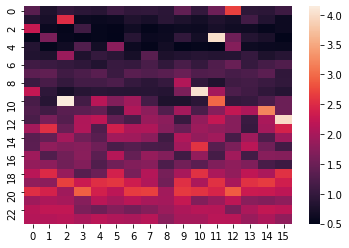

In [21]:
sns.heatmap(avg_loss)

### More Ideas

#### With a little help from BERT-Large

#### Try out Manifold

In [212]:
%pip install --no-cache-dir mlvis

Note: you may need to restart the kernel to use updated packages.


In [7]:
!/vol/scratch/guy/miniconda/bin/jupyter nbextension install --py --symlink --user mlvis
!/vol/scratch/guy/miniconda/bin/jupyter nbextension enable --py --user mlvis

Installing /vol/scratch/guy/miniconda/lib/python3.8/site-packages/mlvis/static -> mlvis
Symlinking: /specific/a/home/cc/students/cs/dar/.local/share/jupyter/nbextensions/mlvis -> /vol/scratch/guy/miniconda/lib/python3.8/site-packages/mlvis/static
- Validating: problems found:
   X  require: /specific/a/home/cc/students/cs/dar/.local/share/jupyter/nbextensions/mlvis/extension.js
  OK section: notebook
Full spec: {'section': 'notebook', 'src': 'static', 'dest': 'mlvis', 'require': 'mlvis/extension'}

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable mlvis --user --py
    
Enabling notebook extension mlvis/extension...
      - Validating: problems found:
        - require?  X mlvis/extension


#### Get "clean" attention heads

In [135]:
def cleanseAttentions(att):
    att_ = att.clone()
    mymax = att.max(axis = -1)[0].unsqueeze(-1)
    threshold = mymax * .25
    att_[att < threshold] = 0
    att_[att >= threshold] = 1
    return att_

In [10]:
(modelA, modelB, encodedA_list, encodedB_list, 
            wordsToTokensA_list, wordsToTokensB_list) = (bertModel, gptModel, bertEncoded, gptEncoded, 
                                  bertWordsToTokens, gptWordsToTokens)


In [194]:
def goodAttention(attentionsA):
  return ((attentionsA.topk(5, axis = -1)[0].sum(axis =-1, keepdims = False ) > 0.7)
         & (attentionsA.topk(2, axis = -1)[0].sum(axis =-1, keepdims = False ) < 0.7)
  ).type('torch.FloatTensor')
  # (cleanseAttentions(attentionsA)
  #                 .topk(3, axis = -1)[0].sum(axis =-1, keepdims = False ) > 0.5).type('torch.FloatTensor')

In [204]:
from tqdm import tqdm_notebook
nSamples = len(encodedA_list)
s = torch.zeros((24,16))
with torch.no_grad():
  for (encodedA, wordsToTokensA) in tqdm_notebook(
                                          zip(encodedA_list, wordsToTokensA_list), total = len(encodedA_list)):
          
          N = len(wordsToTokensA) # TODO: Fix N to the right formula
          attentionsA = _getAttentionsReshaped(largeBertModel(**encodedA), 
                                               wordsToTokens = None, 
                                               reshape = False)
          curS = (goodAttention(attentionsA)
                  .mean(axis = -1, keepdims = False))
          s += curS
                  
s = s/nSamples

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


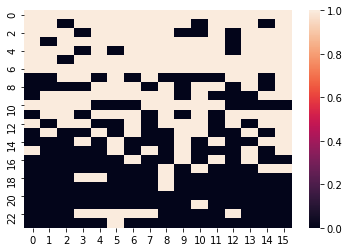

In [207]:
sns.heatmap(s < 0.25)

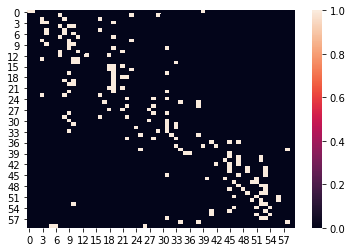

In [263]:
layer =  11
head =  10


x = attentionsA[layer, head]
a = []
y = x.topk(3, axis = 0)[1].tolist()
for y_ in y:
  a+=list(enumerate(y_))

z = torch.zeros(*x.shape)
for a_ in a:
  z[a_] = 1
sns.heatmap(z) # Why axis = -1 is not the right one


In [193]:
pd.DataFrame(s.numpy())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.013750,0.860000,0.968333,0.016917,0.036750,0.014417,0.000750,0.001500,0.009000,0.982332,0.080000
1,0.065333,0.980916,0.081167,0.069333,0.982916,0.187833,1.000000,0.044583,0.013417,0.019417,0.370500,0.269583
2,1.000000,0.960000,0.730750,0.110750,0.328500,0.144333,0.698167,0.117833,0.249667,1.000000,0.258833,0.210917
3,0.979000,0.073250,0.445333,0.836583,0.247000,1.000000,0.216167,0.177667,0.201167,0.999667,0.466417,0.960083
4,0.511417,0.041583,0.520833,0.996000,0.138500,0.964250,0.535167,0.998000,0.681583,0.184167,0.811750,0.985999
5,0.980667,1.000000,0.274250,0.798666,0.162250,0.936000,0.999833,0.980666,0.572833,0.999833,0.997500,0.969000
6,0.875250,0.718917,0.902250,1.000000,0.967917,0.922250,0.993666,0.153083,0.768000,0.990000,0.984000,0.999833
7,0.764000,0.901667,0.992833,0.999667,0.998167,0.506333,1.000000,0.999667,0.780333,0.983000,0.970583,0.999667
8,0.951667,0.358917,0.983166,0.726000,0.921417,0.990666,0.995500,0.362833,0.086250,0.685250,0.828667,0.759083
9,0.745583,0.758167,0.423833,0.834500,0.818750,0.181167,0.883000,0.923167,0.260000,0.832833,0.416667,0.202500


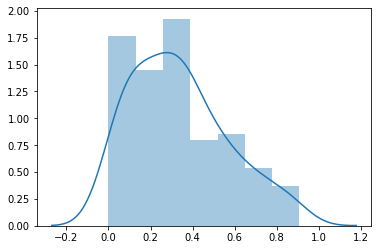

In [178]:
sns.distplot(s.numpy().ravel())

##### With padding

In [24]:
num_sentences = 4000
bertEncoded = bertTokenizerFast.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True, max_length=512, return_tensors='pt', truncation=True).to(device)
gptEncoded = gptTokenizerFast.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True,  max_length=512, return_tensors='pt', truncation=True).to(device)
robertaEncoded = robertaTokenizer.batch_encode_plus(sentences[:num_sentences],pad_to_max_length = True, max_length=512, return_tensors='pt', truncation=True).to(device)

NameError: name 'bertTokenizerFast' is not defined

##### Check encoding alignment

In [ ]:
print(len(bertTokenizer.encode(sentences[1])))

304


In [ ]:
a = list(map(lambda x: len(x[1])-len(x[0]), zip(gptEncoded['input_ids'], bertEncoded['input_ids'])))

In [ ]:
def _sliceToBatches(encoded, batch_size):
    batches = []
    return [{k:v[i*batch_size:(1+i)*batch_size] for k,v in encoded.items()} 
                                    for i in range(int(np.ceil(len(encoded['input_ids'])/batch_size)))]

def headSimilarityWithPadding(modelA, modelB, encodedA_list, encodedB_list):
    res = None
    for encodedA, encodedB in tqdm(zip(encodedA_list, encodedB_list), total = len(encodedA_list)):
        N = len(encodedA['input_ids'][0])
        attentionsA = _getAttentionsReshaped(modelA(**encodedA))
        attentionsB = _getAttentionsReshaped(modelB(**encodedB)) # ( nLayers * nHeads, batch * N * N)
        denom = attentionsA.size(1) / N
        new_res = ((attentionsA @ attentionsB.transpose(0, 1))/denom).detach().numpy()
        if res is None:
            res=new_res
        else:
            res+=new_res
    
    return res/len(encodedA_list)

In [ ]:
sim_mat = headSimilarityWithPadding(robertaModel, bertModel,_sliceToBatches(robertaEncoded, 10), _sliceToBatches(bertEncoded, 10) )

## More

In [ ]:
class AttentionCombiner(nn.Module):
    def __init__(self, n_total_heads = 12 * 12, c = 1./100):
        super(AttentionCombiner, self).__init__()
        self.n_total_heads = n_total_heads
        self.weight = nn.Parameter(torch.ones((self.n_total_heads,1, 1)) * c)
        

    def init_weights(self, a = 0):
        nn.init.constant_(self.weight, a)
        
    def forward(self, x):
        x = x.view(self.n_total_heads, x.size(2), x.size(3))
        w = F.softmax(self.weight)
        # w /= w.sum(axis = 0, keepdims = True)
        x = (w * x).sum(axis = 0)
        return x #F.softmax(x, dim = -1)

class AttentionConverter(nn.Module):
    def __init__(self):
        super(AttentionConverter, self).__init__()
        self.combiner1 = AttentionCombiner()
        self.combiner2 = AttentionCombiner()
        self.combiner3 = AttentionCombiner()

#         self.cnn = nn.Conv1d(1, 1, 3, padding = 1)
#         nn.init.xavier_uniform_(self.cnn.weight)

    def forward(self, x):
        shape = x.shape
#         x = self.cnn(x.view(-1, 1, x.size(-1)))
#         x = x.view(*shape)
        x = (self.combiner1(x) + self.combiner2(x) + self.combiner3(x))/3    
        return x #F.softmax(x.view(x.size(-1), x.size(-1)), dim = -1)
        

In [ ]:
# wandb.init(project="advanced-nlp-2020")
avg_loss = np.empty((24,16))
avg_loss[:] = np.nan
beta = 0.9
attConv = AttentionCombiner()
optimizer = torch.optim.Adam(attConv.parameters(), lr = 0.3)
criterion = nn.KLDivLoss(reduction = 'batchmean')
# wandb.watch(attConv, log = 'all')

for layer in range(24):
    t = (range(16))
    for head in t:
        print("{} {}".format(layer, head))
#         scheduler = (torch.optim.lr_scheduler
#                      .ReduceLROnPlateau(optimizer, factor = 0.5, patience = 15, 
#                                                                threshold = 1e-3,
#                                                                min_lr = 1e-5,
#                                                               verbose = False))
        attConv.init_weights(1)
        for e in range(15):
            for i in range(len(inputs_memmap)):
              attConv.zero_grad()
              cur_inputs = inputs_memmap[i]
              cur_target = target_memmap[i, layer, head]
              sent_len = _getSentLen(cur_target[0])
              inputs = torch.from_numpy(cur_inputs[:, :,  :sent_len, :sent_len]).detach()
              target = torch.from_numpy(cur_target[ :sent_len, :sent_len]).detach()
              loss = criterion(torch.log(attConv(inputs) + 1e-8), target)
              if np.isnan(avg_loss[layer, head]):
                    avg_loss[layer, head] = loss.item()

              avg_loss[layer, head] = beta * avg_loss[layer, head] + (1-beta) * loss.item()
              loss.backward()
              optimizer.step()

              # wandb.log({"Loss": avg_loss[layer, head], 
              #            "Weight": torch.norm(attConv.weight),
              #           "layer": layer, "head":  head 
              #           }  )

#               t.set_postfix_str("Layer: {} Head: {} Loss: {}" .format(layer, head, avg_loss[layer, head]) )
            
#             scheduler.step(avg_loss[layer, head])


In [ ]:
selfAtt = bertModel.encoder.layer[0].attention.self
BertSelfAttention = selfAtt.__class__

In [ ]:
import math
def _nakedAttention(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        if encoder_hidden_states is not None:
            mixed_key_layer = self.key(encoder_hidden_states)
            mixed_value_layer = self.value(encoder_hidden_states)
            attention_mask = encoder_attention_mask
        else:
            mixed_key_layer = self.key(hidden_states)
            mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask
        
        return attention_scores


In [ ]:

def setNakedAttentionHook(model):
  allSelfAtts = (filter(lambda x: isinstance(x, BertSelfAttention), model.modules()))
  model._myForwardHooks = []
  def _saveNakedAttention(self, inp, outp):
    model._myNakedAttentions.append(np.squeeze(_nakedAttention(self, *inp).detach().numpy(), 0))
    
  for selfAtt in allSelfAtts:
    model._myForwardHooks.append(selfAtt.register_forward_hook(_saveNakedAttention))
  

In [ ]:
list(map(lambda x: x.remove(), bertModel._myForwardHooks ))
list(map(lambda x: x.remove(), largeBertModel._myForwardHooks ))

In [ ]:
setNakedAttentionHook(bertModel)
setNakedAttentionHook(largeBertModel)

In [ ]:
max_sent_len = 60
full_target = True

target_shape = (100, 24, 16, max_sent_len, max_sent_len) if full_target else (100, max_sent_len, max_sent_len)
inputs_memmap_naked = np.memmap(guy_folder + "/inputs_no_softmax.memmap", dtype = 'float32', shape = (100, 12, 12, max_sent_len, max_sent_len), mode = "w+")
target_memmap_naked = np.memmap(guy_folder + "/target_no_softmax.memmap", dtype = 'float32', shape = target_shape, mode = "w+")

inputs_memmap_naked[:] = None
target_memmap_naked[:] = None

from tqdm import tqdm_notebook
t = tqdm_notebook(enumerate(bertEncoded))
for i, encodedA in t:
        bertModel._myNakedAttentions = []
        largeBertModel._myNakedAttentions = []
        bertModel(**encodedA)
        inputs = np.stack(bertModel._myNakedAttentions)
        largeBertModel(**encodedA)
        target = np.stack(largeBertModel._myNakedAttentions)

        
        sent_len = target.shape[-1]
        inputs_memmap_naked[i, :, :, :sent_len, :sent_len] = inputs
        target_memmap_naked[i, :, :, :sent_len, :sent_len] = target



inputs_memmap_naked.flush()
target_memmap_naked.flush()


In [ ]:
# wandb.init(project="advanced-nlp-2020")
avg_loss = np.empty((24,16))
avg_loss[:] = np.nan
beta = 0.9
attConv = AttentionCombiner()
optimizer = torch.optim.Adam(attConv.parameters(), lr = 0.3)
criterion = nn.KLDivLoss(reduction = 'batchmean')
# wandb.watch(attConv, log = 'all')

for layer in range(24):
    t = (range(16))
    for head in t:
        print("{} {}".format(layer, head))
#         scheduler = (torch.optim.lr_scheduler
#                      .ReduceLROnPlateau(optimizer, factor = 0.5, patience = 15, 
#                                                                threshold = 1e-3,
#                                                                min_lr = 1e-5,
#                                                               verbose = False))
        attConv.init_weights(1)
        for e in range(15):
            for i in range(len(inputs_memmap)):
              attConv.zero_grad()
              cur_inputs = inputs_memmap_naked[i]
              cur_target = target_memmap_naked[i, layer, head]
              sent_len = _getSentLen(cur_target[0])
              inputs = torch.from_numpy(cur_inputs[:, :,  :sent_len, :sent_len]).detach()
              target = torch.from_numpy(cur_target[ :sent_len, :sent_len]).detach()
              loss = criterion(torch.log(F.softmax(attConv(inputs), -1) + 1e-8), F.softmax(target, -1))
              if np.isnan(avg_loss[layer, head]):
                    avg_loss[layer, head] = loss.item()

              avg_loss[layer, head] = beta * avg_loss[layer, head] + (1-beta) * loss.item()
              loss.backward()
              optimizer.step()

              # wandb.log({"Loss": avg_loss[layer, head], 
              #            "Weight": torch.norm(attConv.weight),
              #           "layer": layer, "head":  head 
              #           }  )

#               t.set_postfix_str("Layer: {} Head: {} Loss: {}" .format(layer, head, avg_loss[layer, head]) )
            
#             scheduler.step(avg_loss[layer, head])
